<a href="https://colab.research.google.com/github/Amandacorreia1/simulacao_computacional_AHLR-vs-aleatorio/blob/main/codigofinal_tcc_amanda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INICIANDO SIMULAÇÃO: G1 (Aleatório) vs G2 (A-HLR) com p=0.7 e p=0.9

Horizonte: 25 dias


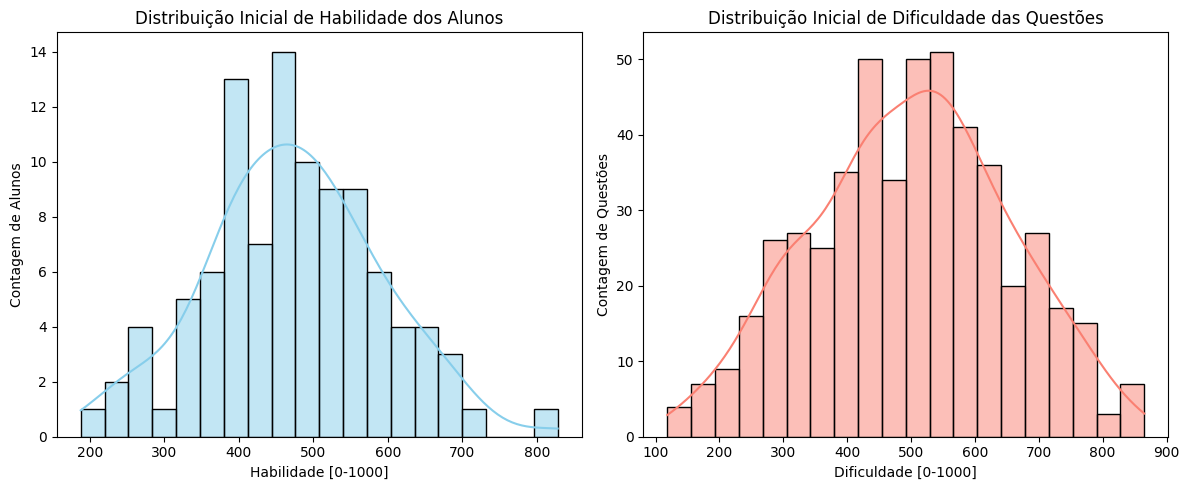

H25: 100%|██████████| 25/25 [00:06<00:00,  3.69it/s]


Horizonte: 50 dias


H50: 100%|██████████| 50/50 [00:12<00:00,  4.08it/s]


Horizonte: 75 dias


H75: 100%|██████████| 75/75 [00:18<00:00,  4.09it/s]


Horizonte: 100 dias


H100: 100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


Horizonte: 150 dias


H150: 100%|██████████| 150/150 [00:34<00:00,  4.35it/s]



[TABELA DE CARGA DE REVISÃO — Média de Respostas por Aluno]
algoritmo                   G1 p=0.0  G2 p=0.7  G2 p=0.9
horizonte_dias q_subtema                                
25             Arvore          19.84     11.81     17.38
               Fila            20.22     11.51     17.29
               Grafo           20.39     11.25     16.83
               Lista           19.88     11.85     16.67
               Pilha           19.68     11.89     17.57
               Total Geral    100.00     58.31     85.74
50             Arvore          40.17     17.53     24.95
               Fila            39.86     16.91     24.23
               Grafo           39.76     17.01     23.55
               Lista           40.28     17.55     24.03
               Pilha           39.93     18.21     24.18
               Total Geral    200.00     87.21    120.93
75             Arvore          60.11     17.45     25.04
               Fila            60.08     17.93     25.05
               Grafo       

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import truncnorm
from tqdm import tqdm
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import anova_lm
import warnings
warnings.filterwarnings("ignore")



# Taxonomia de Fallbacks
FALLBACK_NONE = 'none'
FALLBACK_LEVEL1 = 'level1_urgency'
FALLBACK_LEVEL2 = 'level2_item_selection'
FB_REASON_OK = 'ok'
FB_REASON_NO_URGENT_SUBTOPIC = 'no_subtopic_below_threshold'
FB_REASON_NO_ITEMS_IN_RANGE = 'no_items_in_difficulty_range'
FB_REASON_MSI_BLOCKED = 'msi_blocked_all_candidates'
FB_REASON_USED_ALL_SUBTEMA = 'range_empty_used_all_subtema'

# Configurações do experimento
N_ROUNDS = 3
FIXED_SEED_INIT = 42
THRESHOLDS_P = [0.9, 0.7]
HORIZONTES_A_TESTAR = [25, 50, 75, 100, 150]
N_STUDENTS = 100
N_GROUP = 50
N_QUESTIONS = 500
N_SUBTEMAS = 5
N_QUESTIONS_PER_SUBTEMA = N_QUESTIONS // N_SUBTEMAS
CARGA_PRATICA = 4
MIN_SPACING_INTERVAL = 10
H_MIN = 1.0
H_MAX = 365.0
K_ABILITY_UPDATE = 32
P_TARGET_ITEM_SELECTION = 0.50
DIFFICULTY_RANGE_MARGIN = 150

# Subtemas
SUBTEMAS = ['Pilha', 'Fila', 'Lista', 'Arvore', 'Grafo']

def get_truncated_normal(mean=0, sd=1, low=0, high=1000, size=1):
    return truncnorm((low - mean) / sd, (high - mean) / sd, loc=mean, scale=sd).rvs(size=size)

def fibonacci(n):
    if n <= 1: return 1
    a, b = 1, 1
    for _ in range(2, n + 1):
        a, b = b, a + b
        if a > 1000000: return b
    return b

# Probabilidade base Elo (Bradley-Terry com escala 400)
def simple_logistic_prob(ability, difficulty):
    return 1 / (1 + 10 ** ((difficulty - ability) / 400))

rng = np.random.default_rng()

def get_dynamic_kappa(total_interactions, kappa_max=50, kappa_min=10, growth_rate=0.5):
    kappa = kappa_min + total_interactions * growth_rate
    return np.clip(kappa, kappa_min, kappa_max)

def sample_with_overdispersion(p, kappa=50):
    alpha = max(p * kappa, 1e-6)
    beta = max((1 - p) * kappa, 1e-6)
    p_pert = rng.beta(alpha, beta)
    return 1 if rng.random() < p_pert else 0

# Probabilidade generalizada com retenção A-HLR
def generalized_probability(ability, difficulty, dt, h, h_cost=1.0):
    base_prob = simple_logistic_prob(ability, difficulty)
    dt_effective = dt * h_cost
    retention_rate = 0.5 ** (dt_effective / h)
    p_acerto = base_prob * retention_rate
    return np.clip(p_acerto, 0.01, 0.99)

def update_ability(student, q, result):
    K = K_ABILITY_UPDATE
    p_acerto_update = simple_logistic_prob(student.ability, q.difficulty)
    correction = K * (result - p_acerto_update)
    new_ability = student.ability + correction
    student.ability = np.clip(new_ability, 0.0, 1000.0)
    if student.group == 'G2':
        student.h_cost = 1 - (student.ability / 1000)
    return correction, p_acerto_update

class Question:
    def __init__(self, q_id, subtema, difficulty):
        self.q_id = q_id
        self.subtema = subtema
        self.difficulty = difficulty
        self.h = H_MIN
        self.last_day_seen = 0
    def __repr__(self):
        return f"Q{self.q_id} ({self.subtema}, D:{self.difficulty:.0f}, h:{self.h:.1f})"

class Student:
    def __init__(self, s_id, group, ability, threshold=0.0):
        self.s_id = s_id
        self.group = group
        self.threshold = 0.0 if group == 'G1' else threshold
        self.ability = ability
        self.h_cost = 1.0 if group == 'G1' else 1 - (ability / 1000)
        self.history = []
        self.correct_count = 0
        self.error_count = 0
        self.questions_state = {}
        self.random_sequence_index = 0
        self.subtema_h = {t: H_MIN for t in SUBTEMAS}
        self.subtema_last_seen = {t: 0 for t in SUBTEMAS}
        self.subtema_total_interactions = {t: 0 for t in SUBTEMAS}
        self.subtema_correct_streak = {t: 0 for t in SUBTEMAS}
        self.subtema_error_streak = {t: 0 for t in SUBTEMAS}
    def __repr__(self):
        return f"S{self.s_id} (G:{self.group}, A:{self.ability:.0f})"

# Atualização da meia-vida
def update_half_life(q, student, result):
    subtema = q.subtema
    h_current = student.subtema_h[subtema]
    ratio = student.ability / (q.difficulty + 1e-6)
    inv_ratio = (q.difficulty + 1e-6) / (student.ability + 1e-6)
    if result == 1:
        student.subtema_correct_streak[subtema] += 1
        student.subtema_error_streak[subtema] = 0
        n = student.subtema_correct_streak[subtema]
        h_new = h_current + ratio * fibonacci(n)
    else:
        student.subtema_error_streak[subtema] += 1
        student.subtema_correct_streak[subtema] = 0
        n = student.subtema_error_streak[subtema]
        h_new = H_MIN + inv_ratio * fibonacci(n) / 10
    student.subtema_h[subtema] = np.clip(h_new, H_MIN, H_MAX)

def msi_ok(q, current_day):
    return (q.last_day_seen == 0) or ((current_day - q.last_day_seen) >= MIN_SPACING_INTERVAL)

# Seleção de item dentro do subtema (alvo p ≈ 0.5)
def select_best_item_for_macro_topic(student, subtema_escolhido, current_day):
    target_p = P_TARGET_ITEM_SELECTION
    best_q = None
    min_diff = float('inf')
    h_ability = student.ability
    margin = DIFFICULTY_RANGE_MARGIN
    lower_bound = np.clip(h_ability - margin, 0, 1000)
    upper_bound = np.clip(h_ability + margin, 0, 1000)
    questions_in_topic = [
        q for q_id, q in student.questions_state.items()
        if (q.subtema == subtema_escolhido and
            q.difficulty >= lower_bound and
            q.difficulty <= upper_bound)
    ]
    range_empty = (len(questions_in_topic) == 0)
    if student.group == 'G2':
        questions_in_topic = [q for q in questions_in_topic if msi_ok(q, current_day)]
    level2_reason = FB_REASON_OK
    if not questions_in_topic:

        questions_in_topic_all = [
            q for q_id, q in student.questions_state.items()
            if q.subtema == subtema_escolhido
        ]
        questions_in_topic = questions_in_topic_all  # Sem filtro MSI
        if not questions_in_topic:
            reason = FB_REASON_NO_ITEMS_IN_RANGE if range_empty else FB_REASON_MSI_BLOCKED
            return None, 0, True, FALLBACK_LEVEL2, reason
        level2_reason = FB_REASON_USED_ALL_SUBTEMA
    for q in questions_in_topic:
        p_base = simple_logistic_prob(student.ability, q.difficulty)
        diff = abs(p_base - target_p)
        if diff < min_diff:
            min_diff = diff
            best_q = q
    if best_q is None and questions_in_topic:
        best_q = questions_in_topic[0]
    dt = current_day - student.subtema_last_seen.get(subtema_escolhido, 0)
    h_subtema = student.subtema_h.get(subtema_escolhido, H_MIN)
    p_est_revisao = generalized_probability(student.ability, best_q.difficulty, dt, h_subtema, student.h_cost)
    is_fallback = (level2_reason != FB_REASON_OK)
    return best_q, p_est_revisao, is_fallback, (FALLBACK_LEVEL2 if is_fallback else FALLBACK_NONE), level2_reason

# Seleção de subtema urgente e item (com retenção base 2)
def select_question(student, current_day, threshold_p):
    if student.group == 'G1':
        # Seleção aleatória para G1
        candidates = list(student.questions_state.values())
        if not candidates:
            return None, 0.0, True, FALLBACK_LEVEL1, FB_REASON_NO_URGENT_SUBTOPIC
        selected_q = rng.choice(candidates)
        subtema = selected_q.subtema
        dt = current_day - student.subtema_last_seen.get(subtema, 0)
        h_subtema = student.subtema_h.get(subtema, H_MIN)
        p_est = generalized_probability(student.ability, selected_q.difficulty, dt, h_subtema, student.h_cost)
        is_fallback = False
        fb_stage = FALLBACK_NONE
        fb_reason = FB_REASON_OK
        return selected_q, p_est, is_fallback, fb_stage, fb_reason
    else:
        # Lógica A-HLR para G2
        subtema_urgency = {}
        for subtema in student.subtema_h.keys():
            dt = current_day - student.subtema_last_seen[subtema]
            h_subtema = student.subtema_h[subtema]
            dt_effective = dt * student.h_cost
            p_retention = 0.5 ** (dt_effective / h_subtema)
            if p_retention < threshold_p:
                subtema_urgency[subtema] = p_retention
        if subtema_urgency:
            subtema_escolhido = min(subtema_urgency, key=subtema_urgency.get)
            lvl1_fallback = False
            lvl1_reason = FB_REASON_OK
        else:
            return None, 0.0, True, FALLBACK_LEVEL1, FB_REASON_NO_URGENT_SUBTOPIC
        selected_q, p_est_revisao, lvl2_fallback, lvl2_stage, lvl2_reason = select_best_item_for_macro_topic(
            student, subtema_escolhido, current_day
        )
        if selected_q is None:
            return None, 0.0, True, lvl2_stage, lvl2_reason
        is_fallback = lvl1_fallback or lvl2_fallback
        if lvl2_fallback:
            fb_stage = lvl2_stage
            fb_reason = lvl2_reason
        elif lvl1_fallback:
            fb_stage = FALLBACK_LEVEL1
            fb_reason = lvl1_reason
        else:
            fb_stage = FALLBACK_NONE
            fb_reason = FB_REASON_OK
        return selected_q, p_est_revisao, is_fallback, fb_stage, fb_reason

def plot_initial_histograms(abilities, difficulties):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(abilities, bins=20, kde=True, color='skyblue')
    plt.title('Distribuição Inicial de Habilidade dos Alunos')
    plt.xlabel('Habilidade [0-1000]')
    plt.ylabel('Contagem de Alunos')
    plt.subplot(1, 2, 2)
    sns.histplot(difficulties, bins=20, kde=True, color='salmon')
    plt.title('Distribuição Inicial de Dificuldade das Questões')
    plt.xlabel('Dificuldade [0-1000]')
    plt.ylabel('Contagem de Questões')
    plt.tight_layout()
    plt.show()

def run_simulation(students, run_seed, horizonte_temporal):
    daily_stats = []
    np.random.seed(run_seed + 1)
    for day in tqdm(range(1, horizonte_temporal + 1), desc=f"H{horizonte_temporal}"):
        day_results = []
        for student in students:
            praticadas_no_dia = 0
            while praticadas_no_dia < CARGA_PRATICA:
                selected_q, p_est_revisao, is_fallback, fb_stage, fb_reason = select_question(
                    student, day, student.threshold
                )
                if selected_q is None:
                    break
                dt = day - student.subtema_last_seen.get(selected_q.subtema, 0)
                h_dpg = student.subtema_h.get(selected_q.subtema, H_MIN)
                p_acerto = generalized_probability(student.ability, selected_q.difficulty, dt, h_dpg, student.h_cost)
                subtema = selected_q.subtema
                total_interactions = student.subtema_total_interactions[subtema]
                dynamic_kappa = get_dynamic_kappa(total_interactions, kappa_max=50, kappa_min=10, growth_rate=0.5)
                result = sample_with_overdispersion(p_acerto, kappa=50)
                initial_ability = student.ability
                correction, p_acerto_update_prob = update_ability(student, selected_q, result)
                initial_correct = student.subtema_correct_streak[subtema]
                initial_error = student.subtema_error_streak[subtema]
                update_half_life(selected_q, student, result)
                student.subtema_total_interactions[selected_q.subtema] += 1
                final_correct = student.subtema_correct_streak[subtema]
                final_error = student.subtema_error_streak[subtema]
                selected_q.last_day_seen = day
                student.subtema_last_seen[selected_q.subtema] = day
                student.correct_count += result
                student.error_count += (1 - result)
                day_results.append({
                    'run': run_seed,
                    'horizonte_dias': horizonte_temporal,
                    'day': day,
                    'group': student.group,
                    'p_limiar': student.threshold,
                    'student_id': student.s_id,
                    'ability_start': initial_ability,
                    'ability_correction': correction,
                    'ability_end': student.ability,
                    'prob_update_model': p_acerto_update_prob,
                    'h_cost_end': student.h_cost,
                    'is_fallback': is_fallback,
                    'fallback_stage': fb_stage,
                    'fallback_reason': fb_reason,
                    'q_id': selected_q.q_id,
                    'q_subtema': selected_q.subtema,
                    'q_difficulty': selected_q.difficulty,
                    'result': result,
                    'p_acerto_real': p_acerto,
                    'p_est_revisao': p_est_revisao,
                    'h_do_subtema': h_dpg,
                    'h_final': student.subtema_h[selected_q.subtema],
                    'dt': dt,
                    'q_correct_start': initial_correct,
                    'q_error_start': initial_error,
                    'q_correct_end': final_correct,
                    'q_error_end': final_error,
                })
                praticadas_no_dia += 1
        daily_stats.extend(day_results)
    return pd.DataFrame(daily_stats), students

def run_post_test(students, questions_pool, horizonte_temporal):
    test_results = []
    day_test = horizonte_temporal + 1
    for student in students:
        for q_id, q in student.questions_state.items():
            subtema = q.subtema
            dt = day_test - student.subtema_last_seen.get(subtema, 0)
            h_dpg = student.subtema_h.get(subtema, H_MIN)
            p_acerto = generalized_probability(student.ability, q.difficulty, dt, h_dpg, student.h_cost)
            result = 1 if np.random.rand() < p_acerto else 0
            test_results.append({
                'student_id': student.s_id,
                'group': student.group,
                'p_limiar': student.threshold,
                'q_id': q_id,
                'result': result,
                'p_acerto_test': p_acerto,
                'q_subtema': q.subtema,
                'ability_final': student.ability,
                'horizonte_dias': horizonte_temporal
            })
    return pd.DataFrame(test_results)

all_simulation_data = []
all_posttest_data = []

print("INICIANDO SIMULAÇÃO: G1 (Aleatório) vs G2 (A-HLR) com p=0.7 e p=0.9\n")

for horizonte in HORIZONTES_A_TESTAR:
    print(f"Horizonte: {horizonte} dias")

    np.random.seed(FIXED_SEED_INIT)
    difficulties = get_truncated_normal(mean=500, sd=150, low=0, high=1000, size=N_QUESTIONS)
    subthemes = np.repeat(SUBTEMAS, N_QUESTIONS_PER_SUBTEMA)
    np.random.shuffle(subthemes)
    questions_pool = {i+1: Question(i+1, subthemes[i], difficulties[i]) for i in range(N_QUESTIONS)}

    abilities = get_truncated_normal(mean=500, sd=120, low=0, high=1000, size=N_STUDENTS)

    if horizonte == HORIZONTES_A_TESTAR[0]:
        plot_initial_histograms(abilities, difficulties)

    for threshold in THRESHOLDS_P:
        for run in range(1, N_ROUNDS+1):
            run_seed = FIXED_SEED_INIT + run * 1000 + int(threshold * 100)

            students = []
            for i in range(N_STUDENTS):
                group = "G1" if i < N_GROUP else "G2"
                s = Student(i+1, group, abilities[i], threshold)
                s.questions_state = {q.q_id: Question(q.q_id, q.subtema, q.difficulty) for q in questions_pool.values()}
                students.append(s)

            sim_data, final_students = run_simulation(students, run_seed, horizonte)
            all_simulation_data.append(sim_data)

            posttest = run_post_test(final_students, questions_pool, horizonte)
            posttest['run'] = run
            all_posttest_data.append(posttest)


df_sim = pd.concat(all_simulation_data, ignore_index=True)
df_post = pd.concat(all_posttest_data, ignore_index=True)


df_sim['algoritmo'] = df_sim['group'] + ' p=' + df_sim['p_limiar'].astype(str)
df_post['algoritmo'] = df_post['group'] + ' p=' + df_post['p_limiar'].astype(str)


df_interactions = df_sim.groupby(['run', 'algoritmo', 'horizonte_dias', 'student_id', 'q_subtema']).size().reset_index(name='num_interactions')

df_subtema_counts = df_interactions.groupby(['run', 'algoritmo', 'horizonte_dias', 'q_subtema'])['num_interactions'].sum().reset_index()
df_subtema_counts['media_por_aluno'] = df_subtema_counts['num_interactions'] / N_GROUP


df_carga_final_subtemas = df_subtema_counts.groupby(['algoritmo', 'horizonte_dias', 'q_subtema'])['media_por_aluno'].mean().reset_index()


df_total_interactions_student = df_sim.groupby(['run', 'algoritmo', 'horizonte_dias', 'student_id']).size().reset_index(name='num_interactions_total')


df_total_counts = df_total_interactions_student.groupby(['run', 'algoritmo', 'horizonte_dias'])['num_interactions_total'].sum().reset_index()
df_total_counts['media_por_aluno'] = df_total_counts['num_interactions_total'] / N_GROUP


df_total_final = df_total_counts.groupby(['algoritmo', 'horizonte_dias'])['media_por_aluno'].mean().reset_index()
df_total_final['q_subtema'] = 'Total Geral'

df_carga_final = pd.concat([df_carga_final_subtemas, df_total_final], ignore_index=True)



print("\n[TABELA DE CARGA DE REVISÃO — Média de Respostas por Aluno]")
df_pivot = df_carga_final[df_carga_final['q_subtema'].isin(SUBTEMAS + ['Total Geral'])].pivot_table(
    index=['horizonte_dias', 'q_subtema'], columns='algoritmo', values='media_por_aluno', fill_value=0).round(2)
print(df_pivot)

# Análise estatística
print("\n" + "="*60)
print("ANÁLISE ESTATÍSTICA FORMAL")
print("="*60)

df_acc = df_sim.groupby(['run', 'algoritmo', 'horizonte_dias'])['result'].mean().reset_index(name='accuracy')
df_acc['combo'] = df_acc['algoritmo'] + '_H' + df_acc['horizonte_dias'].astype(str)
anova_acc = stats.f_oneway(*[g['accuracy'] for _, g in df_acc.groupby('combo')])
print(f"\nTaxa de Acerto na Prática → ANOVA: F={anova_acc.statistic:.2f}, p={anova_acc.pvalue:.2e}")
if anova_acc.pvalue < 0.05:
    tukey_acc = pairwise_tukeyhsd(df_acc['accuracy'], df_acc['combo'])
    print(tukey_acc)

df_ret = df_post.groupby(['run', 'algoritmo', 'horizonte_dias'])['result'].mean().reset_index(name='retention')
df_ret['combo'] = df_ret['algoritmo'] + '_H' + df_ret['horizonte_dias'].astype(str)
anova_ret = stats.f_oneway(*[g['retention'] for _, g in df_ret.groupby('combo')])
print(f"\nRetenção Final (Pós-teste) → ANOVA: F={anova_ret.statistic:.2f}, p={anova_ret.pvalue:.2e}")
if anova_ret.pvalue < 0.05:
    tukey_ret = pairwise_tukeyhsd(df_ret['retention'], df_ret['combo'])
    print(tukey_ret)

# Repetições
print("\n--- Total de Repetições de Questões (Interações > 1) ---")
df_freq = df_sim.groupby(['run', 'algoritmo', 'horizonte_dias', 'student_id', 'q_id']).size().reset_index(name='freq')
df_freq['repeticoes'] = df_freq['freq'] - 1
df_rep = df_freq.groupby(['run', 'algoritmo', 'horizonte_dias'])['repeticoes'].sum().reset_index()
df_rep['media_por_aluno'] = df_rep['repeticoes'] / N_GROUP
df_rep_final = df_rep.groupby(['algoritmo', 'horizonte_dias'])['media_por_aluno'].mean().reset_index()
df_rep_pivot = df_rep_final.pivot(index='horizonte_dias', columns='algoritmo', values='media_por_aluno').round(2)
print("\nMédia de Repetições por Aluno:")
print(df_rep_pivot)


In [4]:
print("\n" + "="*70)
print("DISTRIBUIÇÃO GERAL DOS NÍVEIS DE FALLBACK (%) - TODAS AS CATEGORIAS")
print("="*70)

fallback_counts = df_sim['fallback_stage'].value_counts(dropna=False)
fallback_perc = (
    fallback_counts
    .div(fallback_counts.sum())
    .mul(100)
    .round(2)
)

order = ['none', 'level1_urgency', 'level2_item_selection']
fallback_table = pd.Series(0.0, index=order)
for cat in order:
    if cat in fallback_perc.index:
        fallback_table[cat] = fallback_perc[cat]


print("Nível de Fallback          | Percentual (%) | Contagem absoluta")
print("-" * 60)
for nivel, perc in fallback_table.items():
    count = fallback_counts.get(nivel, 0)
    print(f"{nivel:<25} | {perc:>12.2f}%   | {count:>15,}")

print("-" * 60)
print(f"Total de interações analisadas: {len(df_sim):,}")
print(f"Total de fallbacks (qualquer nível): {fallback_counts.sum() - fallback_counts.get('none', 0):,}")


DISTRIBUIÇÃO GERAL DOS NÍVEIS DE FALLBACK (%) - TODAS AS CATEGORIAS
Nível de Fallback          | Percentual (%) | Contagem absoluta
------------------------------------------------------------
none                      |        95.12%   |         604,663
level1_urgency            |         0.00%   |               0
level2_item_selection     |         4.88%   |          31,046
------------------------------------------------------------
Total de interações analisadas: 635,709
Total de fallbacks (qualquer nível): 31,046


In [ ]:


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from math import pi

# Config global para alta qualidade
plt.rcParams.update({'figure.dpi': 300, 'savefig.dpi': 300})
sns.set_theme(style="whitegrid")


def finalize_plot(title, filename):
    plt.title(title, fontsize=14, pad=15)
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight')
    plt.show()
    print(f"→ Salvo e exibido: {filename}")


def plot_metrics_by_horizon(df, title, y_label, metric, filename, is_percentage=False):
    fig, ax = plt.subplots(figsize=(10, 6))

    df_agg = df.groupby(['run', 'algoritmo', 'horizonte_dias'])[metric].mean().reset_index()
    ordem_horizontes = sorted(df_agg['horizonte_dias'].unique())

    sns.barplot(
        data=df_agg,
        x='algoritmo',
        y=metric,
        hue='horizonte_dias',
        hue_order=ordem_horizontes,
        palette='viridis',
        errorbar=('ci', 95),
        ax=ax
    )

    if is_percentage:
        for container in ax.containers:
            labels = [f'{v*100:.1f}%' if v is not None else '' for v in container.datavalues]
            ax.bar_label(container, labels=labels, fmt='', label_type='edge', fontsize=9, padding=3)
    else:

        for container in ax.containers:
            ax.bar_label(container, fmt='%.3f', label_type='edge', fontsize=9, padding=3)

    ax.set_ylabel(f'{y_label} (média ± IC 95%)')
    ax.set_xlabel('Algoritmo de Agendamento')
    ax.legend(title='Horizonte (dias)', ncol=3, fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    finalize_plot(title, filename)


plot_metrics_by_horizon(
    df_sim,
    'Taxa de Acerto Média Durante a Prática',
    'Taxa de Acerto',
    'result',
    'fig_01_taxa_acerto_durante_pratica.png',
    is_percentage=True
)

plot_metrics_by_horizon(
    df_post,
    'Retenção Final (Dia N+1) – Taxa de Acerto no Pós-Teste',
    'Taxa de Acerto',
    'result',
    'fig_02_taxa_acerto_pos_teste.png',
    is_percentage=True
)


print("\n--- Frequência Média de Fallback ---")
df_fb = df_sim.groupby(['run', 'algoritmo', 'horizonte_dias'])['is_fallback'].mean().reset_index()
df_fb['porcentagem'] = df_fb['is_fallback'] * 100

fig, ax = plt.subplots(figsize=(10, 6))
ordem_horizontes = sorted(df_fb['horizonte_dias'].unique())

sns.barplot(
    data=df_fb,
    x='algoritmo',
    y='porcentagem',
    hue='horizonte_dias',
    hue_order=ordem_horizontes,
    palette='viridis',
    errorbar=('ci', 95),
    ax=ax
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=9, padding=3)

ax.set_ylabel('Frequência de Fallback (%)')
ax.set_xlabel('Algoritmo de Agendamento')
ax.legend(title='Horizonte (dias)', ncol=3)
ax.grid(axis='y', linestyle='--', alpha=0.5)

finalize_plot('Frequência de Fallback por Algoritmo e Horizonte', 'fig_03_frequencia_fallback.png')

fig, ax = plt.subplots(figsize=(14, 7))

sns.lineplot(
    data=df_sim,
    x='day',
    y='result',
    hue='algoritmo',
    linewidth=2.2,
    errorbar=('ci', 95),
    palette='deep',
    ax=ax
)

ax.axhline(y=0.50, color='red', linestyle='--', linewidth=2.5,
           label='Alvo desejado (p = 0.50)', alpha=0.75)

ax.set_title('Figura Principal 3: Evolução do Desempenho ao Longo dos Dias', fontsize=16, pad=20)
ax.set_xlabel('Dia da Simulação', fontsize=13)
ax.set_ylabel('Proporção de Acertos (média ± IC 95%)', fontsize=13)
ax.set_ylim(0, 1.05)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=11)
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('fig_principal_3_evolucao_desempenho.png', bbox_inches='tight')
plt.show()
print("→ Figura Principal 3 salva e exibida")


print("\n--- Evolução Temporal das Métricas por Horizonte ---")

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_acc, x='horizonte_dias', y='accuracy', hue='algoritmo', marker='o', errorbar=('ci', 95))
plt.xlabel('Horizonte (dias)')
plt.ylabel('Taxa de Acerto Média')
plt.grid(True, linestyle='--')
plt.legend(title='Algoritmo')
finalize_plot('Evolução da Taxa de Acerto Durante a Prática (por horizonte)', 'fig_04_evolucao_taxa_acerto.png')

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_ret, x='horizonte_dias', y='retention', hue='algoritmo', marker='o', errorbar=('ci', 95))
plt.xlabel('Horizonte (dias)')
plt.ylabel('Taxa de Retenção Média')
plt.grid(True, linestyle='--')
plt.legend(title='Algoritmo')
finalize_plot('Evolução da Retenção no Pós-Teste (por horizonte)', 'fig_05_evolucao_retencao.png')


print("\nTodos os gráficos principais foram gerados com percentuais visíveis nas barras onde aplicável.")

In [ ]:
df_sim.to_csv("log_simulacao.csv", index=False, encoding="utf-8")
df_post.to_csv("log_postteste.csv", index=False, encoding="utf-8")
